In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy import stats

RANDOM_STATE = 42

In [2]:
data = pd.read_csv("../data/fraud_data.csv")
data.head()

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  object 
dtypes:

In [4]:
data.isnull().sum() # no null values found

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
city                     0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [5]:
# convert the time into a useable format
data = data.loc[(data["is_fraud"] == "0") | (data["is_fraud"] == "1")].reset_index(drop=True)
data['is_fraud'] = data["is_fraud"].astype("int64")

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], format="%d-%m-%Y %H:%M")
data['trans_date_trans_time'] = data['trans_date_trans_time'].map(lambda x: x.timestamp())

data['dob'] = pd.to_datetime(data['dob'], format="%d-%m-%Y")
data['dob'] = data['dob'].apply(lambda x: x.timestamp())

data['trans_num'] = data['trans_num'].apply(lambda x: int(x, 16))

In [6]:
# dropping merchant, category (for now), city, state, and job
usable_data = data[["trans_date_trans_time", #"category", 
                    "amt", "lat", "long", "city_pop", "dob", "trans_num", "merch_lat", "merch_long", "is_fraud"]]
usable_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14444 entries, 0 to 14443
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14444 non-null  float64
 1   amt                    14444 non-null  float64
 2   lat                    14444 non-null  float64
 3   long                   14444 non-null  float64
 4   city_pop               14444 non-null  int64  
 5   dob                    14444 non-null  float64
 6   trans_num              14444 non-null  object 
 7   merch_lat              14444 non-null  float64
 8   merch_long             14444 non-null  float64
 9   is_fraud               14444 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 1.1+ MB


In [7]:
# cities = data.city.unique()
# print(len(cities))
# states = data.state.unique()
# print(len(states))
# merchants = data.merchant.unique()
# print(len(merchants))
# categories = data.category.unique()
# print(len(categories))
# jobs = data.job.unique()
# print(len(jobs))

In [8]:
# transaction date/time versus fraudness graph...

In [9]:
# pie chart of percentages of categories

In [10]:
# other graphs/visuals
# plt.figure(figsize=(12, 8))
# plt.scatter(data['house_size'], data['bath'], c=data['bathroom_class'], cmap='coolwarm', alpha=0.5)
# plt.xlabel('House Size (sq ft)')
# plt.ylabel('Number of Bathrooms')
# plt.title('Knoxville Houses: Bathrooms vs Size')
# plt.show()

In [11]:
# need to scramble because all of the fraudulent transactions are at the start of the dataset
scrambled_data = usable_data.sample(frac=1, random_state=RANDOM_STATE)
X = scrambled_data[['trans_date_trans_time', 'amt', 'lat', 'long', 'city_pop', 'dob',# 'trans_num' (removed because need to scale it)
                'merch_lat', 'merch_long']].values
y = scrambled_data['is_fraud']
k_models = []
num_samples_per_split = (int)(len(X) / 10)
# datum = X[0:len(X) +20000,:]
for i in range(10):
    # X_2 = X.copy()
    X_train_1 = X[0:i*num_samples_per_split,:]
    X_train_2 = X[(i+1)*num_samples_per_split:,:]
    X_train = np.concatenate((X_train_1, X_train_2))
    X_test = X[i*num_samples_per_split:(i+1)*num_samples_per_split,:]
    
    y_train_1 = y[0:i*num_samples_per_split]
    y_train_2 = y[(i+1)*num_samples_per_split:]
    y_train = np.concatenate((y_train_1, y_train_2))
    y_test = y[i*num_samples_per_split:(i+1)*num_samples_per_split]

    model = LogisticRegression().fit(X_train, y_train)
    k_models.append((X_train, X_test, y_train, y_test, model))
    # print(f"X 1: {len(X_train_1)}, 2: {len(X_train_2)}")
    # print(f" both together: {len(X_train)+len(X_test)}")
    # print(f"y 1: {len(y_train_1)}, 2: {len(y_train_2)}")
    # print(f" both together: {len(y_train)+len(y_test)}")
    # print(f"length of {i}: {len(X_train)}, first index: {X_train_1[-1]}, last index: {X_train_2[0]}")

In [54]:
# kf_10 = KFold(n_splits=10) #, shuffle=True, random_state=rng1)
# scores_k10 = cross_val_score(knn, X_train, y_train, cv=kf_10)
# cross_val_predict()

accuracies = []
CI_lower_bounds = []
CI_upper_bounds = []
matrices = []
# fig, ax = plt.subplots(5,2)
for package in k_models:
    (X_train, X_test, y_train, y_test, model) = package
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(model_accuracy)

    confidence_level = 0.95
    Z = stats.norm.ppf((1+confidence_level)/2)
    n = len(y_test)
    p = model_accuracy
    
    # Compute confidence interval
    CI = Z * np.sqrt(p*(1-p)/n)
    lower_bound = p - CI
    upper_bound = p + CI    
    CI_lower_bounds.append(lower_bound)
    CI_upper_bounds.append(upper_bound)

    matrix = confusion_matrix(y_test, y_pred)   
    matrices.append(matrix)
    
for index, accuracy in enumerate(accuracies):
    print(f"Model {index+1}: {accuracy:.4f}")
print(f"\nMean accuracy {np.mean(accuracies):.4f}")

Model 1: 0.9162
Model 2: 0.9204
Model 3: 0.9217
Model 4: 0.9280
Model 5: 0.9204
Model 6: 0.9287
Model 7: 0.9079
Model 8: 0.9273
Model 9: 0.9294
Model 10: 0.9314

Mean accuracy 0.9231


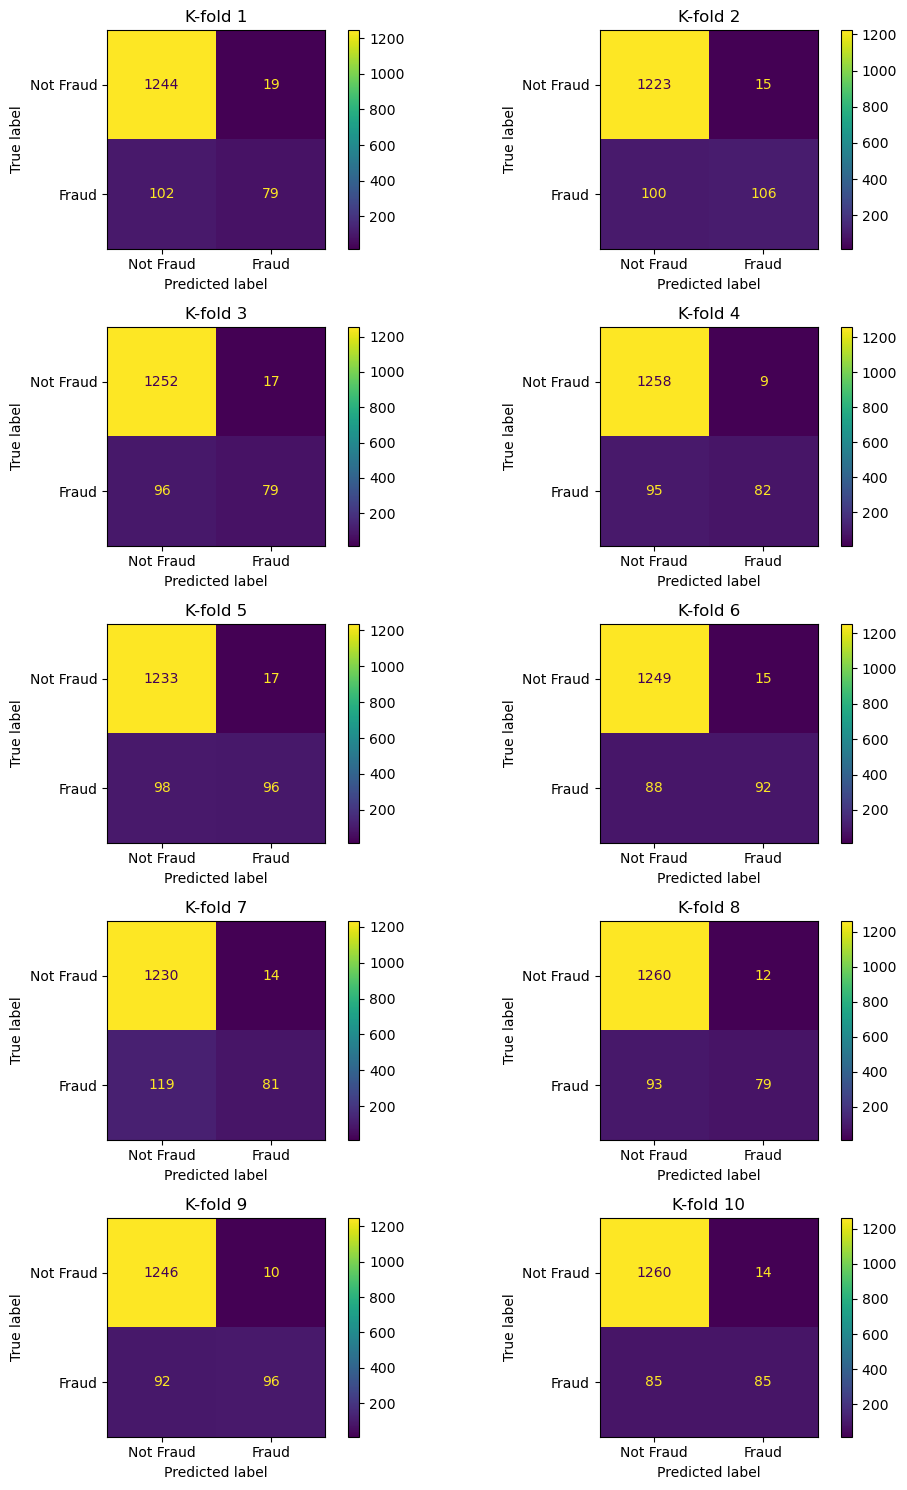

In [31]:
# print confusion matrices
# metrics.ConfusionMatrixDisplay(
#     confusion_matrix=metrics.confusion_matrix(y_test, y_pred), 
#     display_labels=[False, True]).plot(ax=ax[0])
fig, axes = plt.subplots(5, 2, figsize=(10,15))

for index, cm, ax in zip(range(len(matrices)), matrices, axes.flatten()):
    ConfusionMatrixDisplay( 
        confusion_matrix=cm, 
        # display_labels=[False, True]
        display_labels=["Not Fraud", "Fraud"]).plot(ax=ax)
    title = "K-fold "+ str(index +1)
    ax.set_title(title)
plt.tight_layout()  
plt.show()
# matrix_result_average=matrix_result.mean(axis=0)

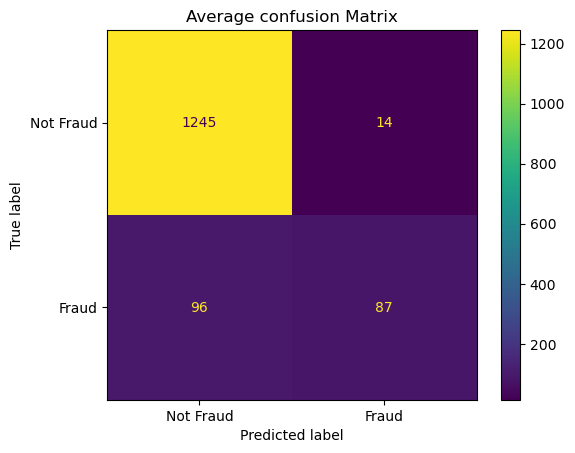

In [36]:
matrix_result_average = np.mean(matrices, axis=0)#matrices.mean(axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_result_average.astype(int), 
                              display_labels=["Not Fraud", "Fraud"])

disp.plot(values_format='d')
plt.title('Average confusion Matrix')
plt.show()

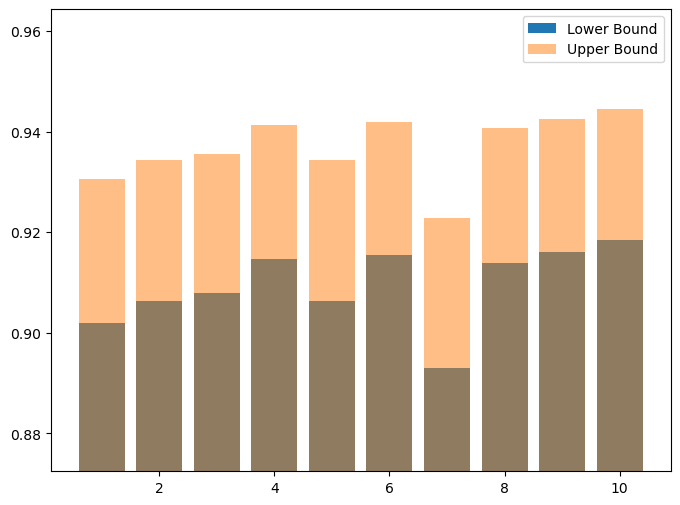

In [53]:
# turn into a bar graph of the accuracies and then a line plot for the confidence intervals (need to change)

labels = [i+1 for i in range(10)]
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(labels, CI_lower_bounds, label="Lower Bound")
ax.bar(labels, CI_upper_bounds, alpha = 0.5, label="Upper Bound")
# Set y-axis limits to zoom in at the top
ymax = max(CI_lower_bounds) * 1.05  # Add a little extra space above the highest bar
ymin = max(CI_lower_bounds) * 0.95   # Set the lower bound close to the max value to zoom in
ax.set_ylim([ymin, ymax])
plt.legend()
plt.show()

In [14]:
### FOR ANANT'S IMPROVEMENT SECTION
# 1) scale the columns (currently we can't use the trans number column at all because sci-kit learn cannot handle it)
# 2) feature selection (one of the ones on the slides)
# 3) feature extraction (one of the ones on the slides)
# 4) stratify (not sure if possible for our current implementation, so check with Deep before you write it on the report)